In [242]:
import os
import json
import pandas as pd
from typing import Dict, Any
from urllib.request import urlretrieve
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
from shapely import wkt
import openrouteservice
import polars as pl
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Preforcast Preprocessing

In [243]:
df = pd.read_csv('../data/curated/forcast_dataset.csv')

In [244]:
df.sort_values(by=['year','month'], inplace=True)

In [245]:
df.value_counts(['year'], ascending=True)


year
2018        60
2019        97
2020       184
2021       448
2022       660
2023       955
2024     11977
2017    149572
2016    155236
2015    165369
Name: count, dtype: int64

In [246]:
sum(df.isnull().sum())

0

In [247]:
df.columns
df.drop(['longitude','latitude','Year'], axis=1, inplace=True)

In [248]:
df.columns

Index(['suburb', 'rent', 'num_bedrooms', 'num_bathrooms', 'parking',
       'distance_to_cbd', 'nearst_train_station_dist', 'year', 'month',
       'num_primary', 'num_secondary_public', 'num_secondary_private',
       'num_secondary_catholic', 'num_edu_centre', 'v_high_vcaa', 'high_vcaa',
       'good_vcaa', 'property_type_apartment / unit / flat',
       'property_type_duplex', 'property_type_duplex-semi-detached',
       'property_type_house', 'property_type_retirement living',
       'property_type_serviced apartment', 'property_type_studio',
       'property_type_townhouse', 'property_type_villa', 'lga',
       'Rate per 100,000 population', 'lga_population'],
      dtype='object')

In [249]:
suburbs  = df['suburb'].unique()



## Quick feature aggregation 

In [250]:
df['avg_distance_to_cbd'] = df.groupby('suburb')['distance_to_cbd'].transform('mean')
df['avg_rent_by_suburb'] = df.groupby('suburb')['rent'].transform('mean')
df['median_rent_by_suburb'] = df.groupby('suburb')['rent'].transform('median')

df.drop('distance_to_cbd', inplace=True, axis=1)

In [251]:
df.columns

Index(['suburb', 'rent', 'num_bedrooms', 'num_bathrooms', 'parking',
       'nearst_train_station_dist', 'year', 'month', 'num_primary',
       'num_secondary_public', 'num_secondary_private',
       'num_secondary_catholic', 'num_edu_centre', 'v_high_vcaa', 'high_vcaa',
       'good_vcaa', 'property_type_apartment / unit / flat',
       'property_type_duplex', 'property_type_duplex-semi-detached',
       'property_type_house', 'property_type_retirement living',
       'property_type_serviced apartment', 'property_type_studio',
       'property_type_townhouse', 'property_type_villa', 'lga',
       'Rate per 100,000 population', 'lga_population', 'avg_distance_to_cbd',
       'avg_rent_by_suburb', 'median_rent_by_suburb'],
      dtype='object')

In [252]:
# df['bath_bed_toghether'] = df['num_bathrooms'] + df['num_bedrooms']
# df['bath_bed_int'] =  df['num_bathrooms']*df['num_bedrooms']


# df.drop(['num_bathrooms','num_bedrooms'], axis=1, inplace=True)

<Axes: xlabel='date'>

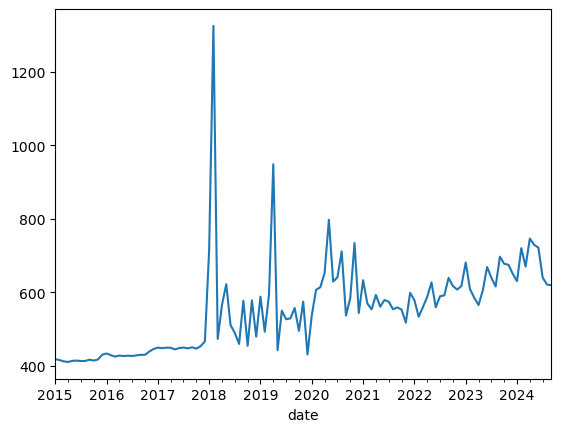

In [253]:
# draw time series plot for rent 
df_draw = df.copy()
df_draw['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df_draw.set_index('date', inplace=True)
df_draw.drop(['year', 'month'], axis=1, inplace=True)

df_draw_plot = df_draw.groupby('date')['rent'].mean()
df_draw_plot.plot()




## Aggregating the data for ARIMA forcast

In [254]:
# df_arima = df.copy()    
# df_arima['date'] = pd.to_datetime(df_arima[['year', 'month']].assign(DAY=1))
# df_arima.set_index('date', inplace=True)

In [255]:
# df_arima.drop(['year','month'], axis=1, inplace=True)

In [256]:
# df_arima_train = df_arima.loc['2015-01-01':'2019-12-01']


## Linear regression per property basis

### Minor Preprocessing

In [257]:


df_reg = df.copy()
df_reg_sub = df_reg[['suburb']]
df_reg.drop(['suburb'], axis=1, inplace=True)
df_reg.drop(['lga'],axis=1, inplace=True)

X = df_reg.drop('rent', axis=1)
y = df_reg['rent']

X_train = X.loc[df_reg['year'] < 2022]
X_test = X.loc[df_reg['year'] >= 2022]
y_train = y.loc[df_reg['year'] < 2022]
y_test = y.loc[df_reg['year'] >= 2022]

df_reg_sub_train = df_reg_sub.loc[df_reg['year'] < 2022]
df_reg_sub_test = df_reg_sub.loc[df_reg['year'] >= 2022]

# y_test = np.log(y_test)
# y_train = np.log(y_train)


(array([2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+00, 4.00000e+00, 5.00000e+00, 3.00000e+01, 2.10000e+01,
        1.00000e+01, 8.00000e+00, 3.80000e+01, 1.68000e+02, 4.49000e+02,
        1.67400e+03, 4.36600e+03, 1.11650e+04, 3.02820e+04, 6.79910e+04,
        1.20931e+05, 9.95060e+04, 5.69780e+04, 4.05980e+04, 2.12640e+04,
        1.33600e+04, 7.20900e+03, 3.54700e+03, 2.17800e+03, 1.35700e+03,
        7.98000e+02, 2.46000e+02, 2.40000e+02, 8.20000e+01, 4.00000e+01]),
 array([0.        , 0.16537464, 0.33074927, 0.49612391, 0.66149855,
        0.82687318, 0.99224782, 1.15762246, 1.32299709, 1.48837173,
        1.65374637, 1.819121  , 1.98449564, 2.14987028, 2.31524491,
        2.48061955, 2.64599419, 2.81136882, 2.97674346, 3.142118

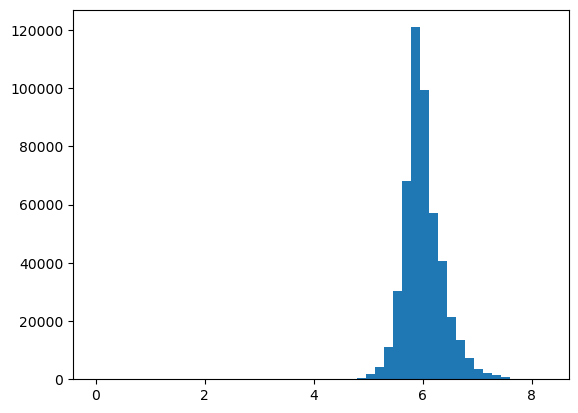

In [258]:

plt.hist(np.log(y), bins=50)

(array([1.7000e+01, 6.7000e+01, 1.1500e+02, 1.3150e+03, 5.2670e+03,
        1.1170e+04, 2.7589e+04, 4.9573e+04, 8.0456e+04, 7.2301e+04,
        5.2865e+04, 4.4359e+04, 3.3807e+04, 1.7848e+04, 2.1213e+04,
        1.3604e+04, 1.1416e+04, 9.1920e+03, 3.0390e+03, 5.4630e+03,
        3.6000e+03, 3.4770e+03, 1.9070e+03, 2.1270e+03, 1.8840e+03,
        1.8110e+03, 1.0430e+03, 3.9900e+02, 1.0460e+03, 3.8100e+02,
        1.0980e+03, 1.9300e+02, 5.2600e+02, 8.0000e+02, 3.5400e+02,
        4.3200e+02, 4.1000e+01, 1.3800e+02, 5.4700e+02, 1.0900e+02,
        5.9000e+01, 2.0900e+02, 1.3300e+02, 1.6700e+02, 1.2700e+02,
        1.1000e+01, 2.0000e+02, 7.4000e+01, 8.1000e+01, 5.9000e+01,
        1.6000e+01, 2.2600e+02, 1.0000e+01, 4.5000e+01, 5.0000e+00,
        2.1000e+01, 9.1000e+01, 2.7000e+01, 3.3000e+01, 4.0000e+00,
        9.0000e+00, 3.3000e+01, 8.0000e+00, 8.0000e+00, 1.0600e+02,
        3.0000e+00, 2.3000e+01, 7.0000e+00, 1.0000e+00, 1.2000e+01,
        1.9000e+01, 2.0000e+01, 2.0000e+00, 2.00

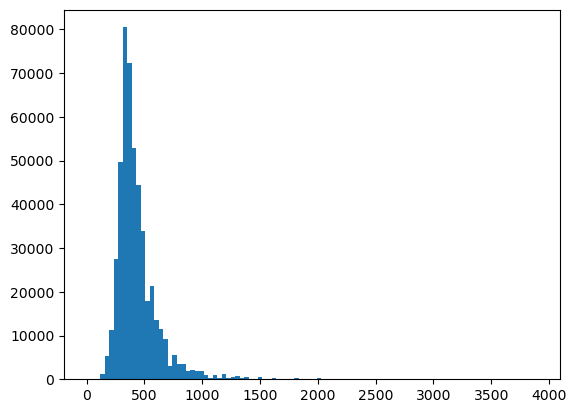

In [259]:
plt.hist((y), bins=100)

In [260]:
X_train.columns
# X_train['lga']

Index(['num_bedrooms', 'num_bathrooms', 'parking', 'nearst_train_station_dist',
       'year', 'month', 'num_primary', 'num_secondary_public',
       'num_secondary_private', 'num_secondary_catholic', 'num_edu_centre',
       'v_high_vcaa', 'high_vcaa', 'good_vcaa',
       'property_type_apartment / unit / flat', 'property_type_duplex',
       'property_type_duplex-semi-detached', 'property_type_house',
       'property_type_retirement living', 'property_type_serviced apartment',
       'property_type_studio', 'property_type_townhouse',
       'property_type_villa', 'Rate per 100,000 population', 'lga_population',
       'avg_distance_to_cbd', 'avg_rent_by_suburb', 'median_rent_by_suburb'],
      dtype='object')

Mean Squared Error: 42298.430066434616
R2 Score: 0.4118363132649804


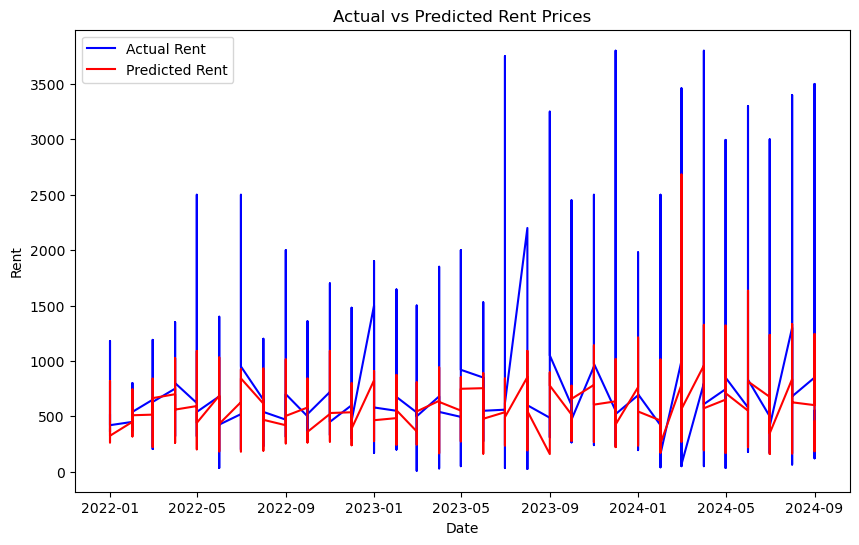

In [261]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred = lin_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(X_test[['year', 'month']].assign(day=1)), y_test, label='Actual Rent', color='blue')
plt.plot(pd.to_datetime(X_test[['year', 'month']].assign(day=1)), y_pred, label='Predicted Rent', color='red')
plt.title('Actual vs Predicted Rent Prices')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend()
plt.show()




In [262]:
result = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred, name='predicted_rent'), df_reg_sub_test.reset_index(drop=True)], axis=1)
print(result.head())

    rent  predicted_rent       suburb
0  510.0      380.287991  craigieburn
1  460.0      378.648745    reservoir
2  720.0      598.222488   cheltenham
3  610.0      533.360992    truganina
4  550.0      537.429479     st kilda


In [263]:
result[result['suburb'] == 'abbotsford']

,rent,predicted_rent,suburb
1411,915.0,721.912106,abbotsford
1664,780.0,706.024897,abbotsford
1850,1800.0,862.510886,abbotsford
1934,900.0,639.713744,abbotsford
2152,800.0,640.654015,abbotsford
...,...,...,...
12864,430.0,498.668313,abbotsford
12945,480.0,489.644837,abbotsford
13075,580.0,557.551548,abbotsford
13124,520.0,489.961788,abbotsford
